In [71]:
import pandas as pd

Был выбран корпус с отзывами из интернет-магазина

In [72]:
df = pd.read_csv("reviews.csv", sep='\t')

In [73]:
df.head()

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative


In [74]:
df = df.drop(df[df.index > 10000].index, 
             axis=0 # удаляем строки, если установлено 1, то удаляться будут столбцы
            )

In [75]:
len(df)

10001

In [76]:
import nltk.data # библиотека Natural Language Toolkit
import re   # библиотека для регулярных выражений
from nltk.corpus import stopwords # стоп-слова из NLTK
from nltk.tokenize import sent_tokenize, RegexpTokenizer  # токенизаторы из NLTK
from nltk.stem import WordNetLemmatizer
nltk.download('punkt') # пунктуация для правильной работы токенизатора

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anastasialobkina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [77]:
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')

In [79]:
from pymorphy2 import MorphAnalyzer

In [81]:
pymorphy2_analyzer = MorphAnalyzer()

In [82]:
lemmatizer = WordNetLemmatizer()

def review_to_wordlist(review, remove_stopwords=False): # хотим получить список слов
    # оставляем только буквенные символы
    review_text = re.sub("[^а-яА-я]"," ", review)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    words = review_text.lower().split()
    if remove_stopwords:
      # убираем стоп-слова
        stops = stopwords.words("russian")
        words = [w for w in words if not w in stops]
    
    words = [pymorphy2_analyzer.parse(w)[0].normal_form for w in words]
    return words

def review_to_sentences(review, tokenizer, remove_stopwords=False): # хотим преобразовать текст списки, каждый список - предложение
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [83]:
rev = df.loc[1]["review"]
rev

'Товар отдали другому человеку, я не получила посылку. Ладно хоть деньги вернули.'

In [84]:
review_to_sentences(rev, tokenizer, remove_stopwords=True)

[['товар', 'отдать', 'другой', 'человек', 'получить', 'посылка'],
 ['ладный', 'деньга', 'вернуть']]

In [85]:
sentences = []  

print("Parsing sentences from training set...")
for review in df["review"]:
    sentences += review_to_sentences(review, tokenizer)

Parsing sentences from training set...


In [86]:
# сохраним очищенный текст в файле clean_text 
# это понадобится нам позже для обучения другой модели эмбеддингов 

with open('clean_text.txt', 'w') as f:
    for s in sentences:
        f.write(' '.join(s))
        f.write('\n')

In [87]:
from gensim.models import word2vec
from gensim.models import Word2Vec

In [88]:
print("Training model...")
# обучаем модель с векторами размерности 300, длиной окна 10
%time model_ru = word2vec.Word2Vec(sentences, workers=4, min_count=10, window=10, sample=1e-3)

Training model...
CPU times: user 2.47 s, sys: 41.4 ms, total: 2.51 s
Wall time: 1.15 s


In [89]:
word = "товар"
model_ru.wv.most_similar(positive=[word], topn=5) # можем посмотреть самые близкие слова

[('заказ', 0.881772518157959),
 ('продавец', 0.8060613870620728),
 ('отвечать', 0.773278534412384),
 ('дождаться', 0.7707937955856323),
 ('пока', 0.7666385769844055)]

## Дообучение

In [90]:
# Читаем корпус, по которому хотим дообучить модель

df1 = pd.read_json("reviews1.json")

In [92]:
df1.head()

,title,description
0,Анимационный ремейк «Гамлета» Уильяма Шекспира...,Главный мультфильм всех времен и народов (но л...
1,А на душе глубокий Шрам,В 1994 году ворвался в мировой кинематограф му...
2,Король лев — неповторимый шедевр на все времена,Начитавшись положительных отзывов о ремейке Ко...
3,Мультфильм на все времена!,Я долго откладывал этот мультфильм в долгий ящ...
4,Лучший на свете анимационный фильм,Анимационный фильм 'Король Лев' 1994 года – на...


In [94]:
sentences1 = []  

print("Parsing sentences from training set...")
for review in df1["title"]:
    sentences1 += review_to_sentences(review, tokenizer)
for review in df1["description"]:
    sentences1 += review_to_sentences(review, tokenizer)

Parsing sentences from training set...


### Сохранение недообученной модели

In [95]:
model_path = "pieces_reviews.model"

# так можно сохранить модель для последующего дообучения
print("Saving model...")
model_ru.save(model_path)

Saving model...


In [96]:
# загружаем нашу обученную модель и дообучаем

model = word2vec.Word2Vec.load(model_path)

model.build_vocab(sentences1, update=True) # clean)sents - это очищенный текст для дообучения
model.train(sentences1, total_examples=model.corpus_count, epochs=5)

(185221, 308115)

## Оценка модели

### Аналогии

In [98]:
pip install wget

  Stored in directory: /Users/anastasialobkina/Library/Caches/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [99]:
!python -m wget https://raw.githubusercontent.com/ancatmara/data-science-nlp/master/data/w2v/evaluation/ru_analogy_tagged.txt

100% [........................................................] 871776 / 871776
Saved under ru_analogy_tagged.txt


In [100]:
with open('ru_analogy_tagged.txt','r') as f:
  data = f.readlines()
  print (data[:10])

[': capital-common-countries\n', 'афины_S греция_S багдад_S ирак_S\n', 'афины_S греция_S бангкок_S таиланд_S\n', 'афины_S греция_S пекин_S китай_S\n', 'афины_S греция_S берлин_S германия_S\n', 'афины_S греция_S берн_S швейцария_S\n', 'афины_S греция_S каир_S египет_S\n', 'афины_S греция_S канберра_S австралия_S\n', 'афины_S греция_S ханой_S вьетнам_S\n', 'афины_S греция_S гавана_S куба_S\n']


In [109]:
res = model.wv.evaluate_word_analogies('ru_analogy_tagged.txt')
res

(0.0,
 [{'section': 'capital-common-countries', 'correct': [], 'incorrect': []},
  {'section': 'capital-world', 'correct': [], 'incorrect': []},
  {'section': 'currency', 'correct': [], 'incorrect': []},
  {'section': 'city-in-state', 'correct': [], 'incorrect': []},
  {'section': 'family', 'correct': [], 'incorrect': []},
  {'section': 'gram1-Aective-to-adverb', 'correct': [], 'incorrect': []},
  {'section': 'gram2-opposite', 'correct': [], 'incorrect': []},
  {'section': 'gram6-nationality-Aective', 'correct': [], 'incorrect': []},
  {'section': 'Total accuracy', 'correct': [], 'incorrect': []}])

### Коэффициент семантической близости

In [140]:
### Пример с предобученной моделью с gensim
import gensim.downloader as download_api
russian_model = download_api.load('word2vec-ruscorpora-300')

In [145]:
russian_model.key_to_index

{'весь_DET': 0,
 'человек_NOUN': 1,
 'мочь_VERB': 2,
 'год_NOUN': 3,
 'сказать_VERB': 4,
 'время_NOUN': 5,
 'говорить_VERB': 6,
 'становиться_VERB': 7,
 'знать_VERB': 8,
 'самый_DET': 9,
 'дело_NOUN': 10,
 'день_NOUN': 11,
 'жизнь_NOUN': 12,
 'рука_NOUN': 13,
 'очень_ADV': 14,
 'первый_ADJ': 15,
 'давать_VERB': 16,
 'новый_ADJ': 17,
 'слово_NOUN': 18,
 'иметь_VERB': 19,
 'большой_ADJ': 20,
 'идти_VERB': 21,
 'глаз_NOUN': 22,
 'место_NOUN': 23,
 'лицо_NOUN': 24,
 'видеть_VERB': 25,
 'хотеть_VERB': 26,
 'понимать_VERB': 27,
 'должный_ADJ': 28,
 'работа_NOUN': 29,
 'каждый_DET': 30,
 'друг_NOUN': 31,
 'голова_NOUN': 32,
 'дом_NOUN': 33,
 'оставаться_VERB': 34,
 'сторона_NOUN': 35,
 'начинать_VERB': 36,
 'думать_VERB': 37,
 'хорошо_ADV': 38,
 'жить_VERB': 39,
 'стоять_VERB': 40,
 'спрашивать_VERB': 41,
 'сделать_VERB': 42,
 'выходить_VERB': 43,
 'последний_ADJ': 44,
 'русский_ADJ': 45,
 'сила_NOUN': 46,
 'получать_VERB': 47,
 'какой-то_DET': 48,
 'хороший_ADJ': 49,
 'случай_NOUN': 50,
 'во

In [154]:
russian_model.most_similar("товар_NOUN", topn=20)

[('перекупной_ADJ', 0.6159310936927795),
 ('покупатель_NOUN', 0.606242299079895),
 ('торговля_NOUN', 0.5966311693191528),
 ('торговец_NOUN', 0.5866560935974121),
 ('торговать_VERB', 0.5858898758888245),
 ('мелочник_NOUN', 0.5858420133590698),
 ('промтовары_NOUN', 0.5821278095245361),
 ('продавец_NOUN', 0.5660276412963867),
 ('неходовой_ADJ', 0.5607762932777405),
 ('оптовый_ADJ', 0.55995112657547),
 ('отвозный_ADJ', 0.5585289597511292),
 ('шолк::сырец_NOUN', 0.554379403591156),
 ('транзитный_ADJ', 0.5505794882774353),
 ('торговый_ADJ', 0.5485782027244568),
 ('пересортица_NOUN', 0.5473554134368896),
 ('закупщик_NOUN', 0.5454196929931641),
 ('товарообменный_ADJ', 0.5447783470153809),
 ('продтовары_NOUN', 0.5443027019500732),
 ('пошлина_NOUN', 0.5437184572219849),
 ('торг_NOUN', 0.543341338634491)]

In [155]:
model.wv.most_similar("товар", topn=20)

[('заказ', 0.881772518157959),
 ('продавец', 0.8060613870620728),
 ('отвечать', 0.7755183577537537),
 ('дождаться', 0.7707937955856323),
 ('пока', 0.7646418809890747),
 ('кормить', 0.7642618417739868),
 ('закончиться', 0.7610161900520325),
 ('защита', 0.7550126910209656),
 ('отказываться', 0.7526035308837891),
 ('обещание', 0.748046338558197),
 ('продлять', 0.7446015477180481),
 ('обещать', 0.7382684946060181),
 ('сообщение', 0.737549901008606),
 ('продлить', 0.7333065867424011),
 ('отказаться', 0.7323172688484192),
 ('ожидание', 0.7303941249847412),
 ('завтрак', 0.7302002906799316),
 ('август', 0.7295315265655518),
 ('посылка', 0.7286016941070557),
 ('контакт', 0.7249263525009155)]

In [156]:
russian_model.most_similar("россия_NOUN", topn=20)

[('страна_NOUN', 0.7258070111274719),
 ('европа_NOUN', 0.6865814924240112),
 ('издание::нти_NOUN', 0.677743136882782),
 ('российский_ADJ', 0.6528498530387878),
 ('польша_NOUN', 0.6130075454711914),
 ('государство_NOUN', 0.601081132888794),
 ('франция_NOUN', 0.5965465307235718),
 ('германия_NOUN', 0.5898338556289673),
 ('украина_NOUN', 0.5847848653793335),
 ('газотранспортный::консорциум_NOUN', 0.5807692408561707),
 ('таджикистан::туркменистан_NOUN', 0.5741675496101379),
 ('снг_NOUN', 0.554931104183197),
 ('лесоэкспортер_NOUN', 0.549642026424408),
 ('европейский_ADJ', 0.5495944023132324),
 ('белоруссия_NOUN', 0.5492621064186096),
 ('шляжявичюс_NOUN', 0.5489081740379333),
 ('китай_NOUN', 0.5484400987625122),
 ('центральноевропейский_ADJ', 0.5470951795578003),
 ('турция_NOUN', 0.5441358685493469),
 ('финляндия_NOUN', 0.5422065854072571)]

In [157]:
model.wv.most_similar("россия", topn=20)

[('китай', 0.9588364958763123),
 ('номер', 0.9400283694267273),
 ('отправка', 0.9350374341011047),
 ('отслеживание', 0.9350244402885437),
 ('чужой', 0.9331404566764832),
 ('потом', 0.9325924515724182),
 ('отслеживать', 0.9301947951316833),
 ('течение', 0.927061915397644),
 ('ожидание', 0.9261312484741211),
 ('затем', 0.9247435331344604),
 ('оплатить', 0.9239160418510437),
 ('москва', 0.9217665195465088),
 ('дать', 0.9204549193382263),
 ('левый', 0.9169347882270813),
 ('истечение', 0.9157975316047668),
 ('потеряться', 0.9156562089920044),
 ('трек', 0.9120206236839294),
 ('дойти', 0.9102200269699097),
 ('посылка', 0.9078086614608765),
 ('пора', 0.9055178165435791)]

In [158]:
russian_model.most_similar("срок_NOUN", topn=20)

[('годность::мес_NOUN', 0.6883343458175659),
 ('истечение_NOUN', 0.6292240023612976),
 ('неотбытый_ADJ', 0.5637102723121643),
 ('исковой::давность_NOUN', 0.5628745555877686),
 ('отсрочка_NOUN', 0.5603160262107849),
 ('начисляться::пеня_VERB', 0.5593971014022827),
 ('неустранение_NOUN', 0.5464380979537964),
 ('пресекательный_ADJ', 0.5410897731781006),
 ('продлеваться_VERB', 0.5355184078216553),
 ('межремонтный_ADJ', 0.5216536521911621),
 ('libor_NOUN', 0.5201770067214966),
 ('дедлайн_NOUN', 0.5175908803939819),
 ('наказываться::лишение_VERB', 0.5141195058822632),
 ('полуторагодичный_ADJ', 0.5106835961341858),
 ('поквартально_ADV', 0.509704053401947),
 ('пролонгация_NOUN', 0.49928954243659973),
 ('продление_NOUN', 0.49905818700790405),
 ('несовершение_NOUN', 0.49895116686820984),
 ('годность_NOUN', 0.49601149559020996),
 ('истекать_VERB', 0.4951167404651642)]

In [159]:
model.wv.most_similar("срок", topn=20)

[('защита', 0.9787859320640564),
 ('продлевать', 0.9733245968818665),
 ('продлить', 0.9687643051147461),
 ('отправка', 0.9403965473175049),
 ('течение', 0.9365389943122864),
 ('кормить', 0.9342001080513),
 ('закончиться', 0.9329739212989807),
 ('ожидание', 0.9329418540000916),
 ('через', 0.9280616641044617),
 ('продлять', 0.9273958802223206),
 ('пройти', 0.9273746609687805),
 ('подождать', 0.9267774820327759),
 ('время', 0.9232618808746338),
 ('истечение', 0.9201764464378357),
 ('обещать', 0.9188920259475708),
 ('завтрак', 0.9187926650047302),
 ('день', 0.9178082346916199),
 ('пока', 0.9161866307258606),
 ('неделя', 0.9109905362129211),
 ('истечь', 0.9109486937522888)]

## Словарь синонимов

In [165]:
from collections import Counter

In [174]:
df["review_tokenized"] = df["review"].apply(lambda x: review_to_wordlist(x, remove_stopwords=True))

In [175]:
df.head()

,review,sentiment,review_tokenized
0,качество плохое пошив ужасный (горловина напер...,negative,"[качество, плохой, пошив, ужасный, горловина, ..."
1,"Товар отдали другому человеку, я не получила п...",negative,"[товар, отдать, другой, человек, получить, пос..."
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative,"[ужасный, синтетик, тонкий, общий, представить..."
3,"товар не пришел, продавец продлил защиту без м...",negative,"[товар, прийти, продавец, продлить, защита, мо..."
4,"Кофточка голая синтетика, носить не возможно.",negative,"[кофточка, голый, синтетик, носить, возможно]"


In [203]:
word_dict = Counter()

for rev in df["review_tokenized"]:
    counter = Counter(rev)
    word_dict.update(counter)

n = len(word_dict)
word_dict = dict(word_dict.most_common(n))
word_dict

{'продавец': 4104,
 'деньга': 3734,
 'товар': 3443,
 'размер': 2687,
 'очень': 2683,
 'вернуть': 2639,
 'прийти': 2366,
 'спор': 2211,
 'заказ': 1866,
 'качество': 1483,
 'л': 1393,
 'это': 1327,
 'заказывать': 1214,
 'приша': 1103,
 'месяц': 1082,
 'открыть': 1077,
 'получить': 1003,
 'заказать': 890,
 'соответствовать': 877,
 'ткань': 866,
 'маленький': 834,
 'ждать': 809,
 'платье': 797,
 'ужасный': 794,
 'цвет': 766,
 'такой': 759,
 'отправить': 745,
 'прислать': 724,
 'фото': 691,
 'посылка': 662,
 'доставка': 644,
 'рукав': 597,
 'вообще': 564,
 'шов': 558,
 'короткий': 550,
 'просто': 543,
 'нитка': 543,
 'быть': 538,
 'рекомендовать': 526,
 'тонкий': 514,
 'советовать': 514,
 'носить': 512,
 'плохой': 490,
 'день': 486,
 'кофта': 485,
 'хороший': 485,
 'торчать': 475,
 'смотреть': 468,
 'долго': 453,
 'синтетик': 443,
 'итог': 436,
 'описание': 431,
 'так': 427,
 'мой': 419,
 'один': 411,
 'оказаться': 405,
 'который': 403,
 'закрыть': 396,
 'другой': 391,
 'сам': 389,
 'хотя':

In [213]:
synonyms = {}

In [214]:
n = 0
keys = list(word_dict.keys())
while keys != [] and n < 50:
    similars = model.wv.most_similar(keys[0], topn=5)
    synonyms[keys[0]] = dict(similars)
    for sim in similars:
        if sim[0] in keys:
            keys.remove(sim[0])
    keys.remove(keys[0])
    n += 1

synonyms

{'продавец': {'сообщение': 0.8443324565887451,
  'обещать': 0.8417447209358215,
  'выслать': 0.8339062929153442,
  'отвечать': 0.826651394367218,
  'просить': 0.8221803903579712},
 'деньга': {'али': 0.7881322503089905,
  'сумма': 0.7771041393280029,
  'алиэкспресс': 0.7750112414360046,
  'средство': 0.7620602250099182,
  'хотеть': 0.7561126351356506},
 'товар': {'заказ': 0.881772518157959,
  'продавец': 0.8060613870620728,
  'отвечать': 0.7755183577537537,
  'дождаться': 0.7707937955856323,
  'пока': 0.7646418809890747},
 'размер': {'м': 0.9467580318450928,
  'оказаться': 0.9266058206558228,
  'российский': 0.9120697379112244,
  'маленький': 0.9036075472831726,
  'параметр': 0.8991633653640747},
 'очень': {'костюм': 0.7647584080696106,
  'сильно': 0.7247253060340881,
  'кофточка': 0.7008165717124939,
  'слишком': 0.6974498629570007,
  'ооочень': 0.6970692276954651},
 'вернуть': {'возвращать': 0.974057674407959,
  'отказаться': 0.8752300143241882,
  'потратить': 0.8609468340873718,
  'в

In [215]:
len(synonyms)

50

## Строим граф

In [227]:
import networkx as nx
import matplotlib.pyplot as plt

In [233]:
def draw_graph(word):
    sims = model.wv.most_similar(positive=[word], topn=5)
    G = nx.Graph()
    edges = [(word, sim[0], round(sim[1], 3)) for sim in sims]
    G.add_weighted_edges_from(edges)
    labels = nx.get_edge_attributes(G, "weight")
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

китай


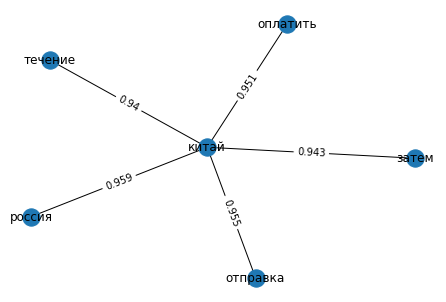

In [234]:
word = input()
draw_graph(word)

Для работы был выбран корпус с отзывами из интернет-магазина, потому что он структурно похож на мой корпус с отзывами к мультфильму "Король Лев".

По оценкам аналогии модель довольно плохая, т.к. в отзывах на товары используют довольно скудный язык, а в обучающем корпусе собраны различные пары слов.

По коэффициенту семантической близости модель тоже не очень хорошая, т.к. в отзывах используют довольно узконаправленные слова, связанные с качеством, ценой и доставкой, в то время как в обучающем корпусе присутствует множество различных комбинаций.